In [1]:
# install dependencies if they aren't
!pip install pytorch-lightning python-dotenv wandb==0.15.0 protobuf==3.20.3 --quiet

# install from git
!if [ -e ./diffusionpokemon ]; then rm -rf ./diffusionpokemon; fi
!git clone https://github.com/LongDangHoang/DiffusionPokemon ./diffusionpokemon

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.6 MB/s eta 0:00:00
Cloning into './diffusionpokemon'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 395 (delta 73), reused 70 (delta 24), pack-reused 232 (from 1)
Receiving objects: 100% (395/395), 1.98 MiB | 24.45 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [2]:
# upgrade s3fs to avoid performance issue
!pip install s3fs==2025.5.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.36.23 requires botocore<1.37.0,>=1.36.23, but you have botocore 1.37.3 which is incompatible.
datasets 3.3.1 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2025.5.1 which is incompatible.


In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./diffusionpokemon")

import re
import os
import torch
import torch.nn as nn
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from typing import List, Dict, Optional, Union, Tuple
from pathlib import Path

from diffusionpokemon.models.autoencoder_blocks import TimeEmbedding
from diffusionpokemon.models.ddpm_unet import DDPMModel, DDPMUNet
from diffusionpokemon.utils.callbacks import SampleCallback, DenoiseMidwaySampleCallback

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping, 
    StochasticWeightAveraging, 
    Callback, 
    ModelCheckpoint,
    LearningRateMonitor,
)

torch.manual_seed(314)
torch.cuda.manual_seed_all(314)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [4]:
## Define hyperparameters
from dotenv import load_dotenv
import json

ON_KAGGLE = False
if not load_dotenv():
    from kaggle_secrets import UserSecretsClient
    os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret("wandb_api")
    os.environ["AWS_ACCESS_KEY_ID"] = UserSecretsClient().get_secret("s3_aws_access_key")
    os.environ["AWS_SECRET_ACCESS_KEY"] = UserSecretsClient().get_secret("s3_aws_secret_access_key")
    ON_KAGGLE = True
    
import wandb

project_name = PROJECT_NAME = "test-ddpm-lightning"

if config_json_filename := os.getenv("CONFIG_JSON_NAME", None):
    with open(config_json_filename, "r") as f:
        config = json.load(f)
else:
    config = dict(
        batch_size = 32,
        use_constant_lr = False,
        lr = 1e-4,
        num_epoch = 1_000,
        dropout = 0.0,
        overfit_batch = 0.0,
        weight_decay = 0.0,
        log_wandb = True,
        init_new_wandb_run = False,
        use_existing_run = "setviymk",
        use_augmentation = True,
        accumulate_grad_batches = 4,
        ddpm__n_steps = 1_000,
        ddpm__input_image_channels = 3,
        ddpm__input_image_size = 32,
        unet__channels_mult = [1, 4, 4, 4, 4, 4],
        unet__is_attn = [False, False, False, True, True, True],
        unet__n_blocks = 12,
        unet__hidden_dim = 64,
        unet__use_conv_for_res_change = True,
        is_finetune = False,
        lr_scheduler__class = "CosineAnnealingLR",
        max_trainer_time_limit = "00:60:00:00",
    )

for k, v in config.items():
    if k not in globals() or globals()[k] != v:
        globals()[k] = v

# start a new wandb run to track this script
if log_wandb:
    wandb.login()

    if "run" not in globals():
        run = wandb.init(
            project=PROJECT_NAME,
            id=use_existing_run if (use_existing_run and not init_new_wandb_run) else None,
            resume="must" if (use_existing_run and not init_new_wandb_run) else None,
            config={
                **config,
                "mode": "offline" if not log_wandb else "online"
            }
        )
        assert run is not None

# some common things
to_pil = transforms.ToPILImage()

def make_normaliser(num_channels=1):
    return transforms.Normalize([0.5]*num_channels, [1]*num_channels) # - 0.5 / 1

def make_inv_normaliser(num_channels=1):
    return transforms.Compose([transforms.Normalize([-0.5]*num_channels, [1]*num_channels), lambda x: torch.clip(x, 0, 1)])

wandb: Currently logged in as: hoanglongdang2001. Use `wandb login --relogin` to force relogin


# Get data

In [5]:
cifar_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    make_normaliser(),
    *(
        [] 
        if not config["use_augmentation"] 
        else [
            transforms.RandomHorizontalFlip(p=0.5),
        ] 
    )
])

train_dataset = datasets.CIFAR10(root="cifar", train=True, transform=cifar_transforms, download=True)
test_dataset = datasets.CIFAR10(root="cifar", train=False, transform=cifar_transforms, download=True)

# # Filter indices where label == 0 (airplane)
# plane_train_indices = [i for i, (_, label) in enumerate(train_dataset) if label == 0]
# plane_test_indices = [i for i, (_, label) in enumerate(test_dataset) if label == 0]

# # Create subsets of only airplanes
# plane_train_set = Subset(train_dataset, plane_train_indices)
# plane_test_set = Subset(test_dataset, plane_test_indices)

# mnist_transforms = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     make_normaliser(),
# ])
# train_dataset = datasets.MNIST(root="mnist", train=True, download=True, transform=mnist_transforms)
# test_dataset = datasets.MNIST(root="mnist", train=False, download=True, transform=mnist_transforms)

100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [6]:
# split train valid
print(f"Train: {len(train_dataset)}, Valid: {len(test_dataset)}")

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

# append steps_per_epoch
effective_batch_size = batch_size * (1 if accumulate_grad_batches is None else accumulate_grad_batches)
num_train_examples = len(train_dataset) if overfit_batch == 0.0 else (overfit_batch * batch_size)
steps_per_epoch = math.ceil(num_train_examples / effective_batch_size)
print("Number of steps per epoch:", f"{steps_per_epoch}")

Train: 50000, Valid: 10000
Number of steps per epoch: 391


Input shape: torch.Size([3, 32, 32])


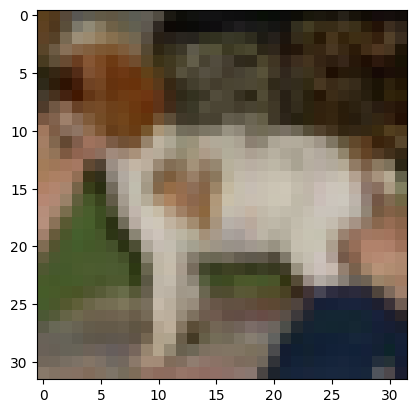

In [7]:
inv_t = make_inv_normaliser()

plt.imshow(to_pil(inv_t(test_dataset[12][0])))

print("Input shape:", test_dataset[0][0].shape)

# Init model

In [8]:
optimizer_kwargs=dict(
    use_constant_lr=config["use_constant_lr"],
    lr_scheduler__class=config["lr_scheduler__class"],
    lr=config["lr"],
    weight_decay=config["weight_decay"],
)

if config["lr_scheduler__class"] == "CosineAnnealingLR":
    optimizer_kwargs["lr_sched_freq__step"] = 1
    optimizer_kwargs["lr_scheduler__kwargs"] = {
        "T_max": config["num_epoch"] * steps_per_epoch,
        "eta_min": config["lr"] / 100
    }
elif config["lr_scheduler_class"] == "ReduceLROnPlateau":
    optimizer_kwargs["lr_sched_freq__step"] = steps_per_epoch
    optimizer_kwargs["lr_scheduler__kwargs"] = {
        "T_max": config["num_epoch"] * steps_per_epoch,
        "eta_min": config["lr"] / 100
    }

model = DDPMUNet(
    n_steps=config["ddpm__n_steps"],
    input_size=config["ddpm__input_image_size"],
    optimizers_kwarg=optimizer_kwargs,
    eps_model_kwargs=dict(
        n_blocks=config["unet__n_blocks"], 
        n_channels=config["unet__hidden_dim"],
        channels_mult=config["unet__channels_mult"], 
        is_attn=config["unet__is_attn"],
        res_block_dropout=config["dropout"],
        use_conv_for_res_change=config["unet__use_conv_for_res_change"],
        input_channels=config["ddpm__input_image_channels"]
    ),
    is_finetune=False,   # we're not interested in finetuning for a while...
).to(device)
       
print(f"Number of trainable params: {sum(p.numel() for p in model.eps_model.parameters() if p.requires_grad):,}")
print("Model device:", model.device)

print(optimizer_kwargs)

Number of trainable params: 235,098,755
Model device: cuda:0
{'use_constant_lr': False, 'lr_scheduler__class': 'CosineAnnealingLR', 'lr': 0.0001, 'weight_decay': 0.0, 'lr_sched_freq__step': 1, 'lr_scheduler__kwargs': {'T_max': 391000, 'eta_min': 1e-06}}


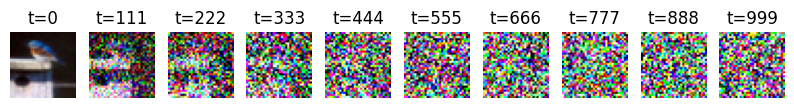

In [9]:
# test model forward noising
sample_img = train_dataset[13][0]

num_imgs = 10
ts = torch.as_tensor(np.round(np.linspace(0, model.n_steps-1, num_imgs)), dtype=torch.long).to(model.device)
x = torch.unsqueeze(sample_img, 0).expand(num_imgs, *sample_img.shape).to(model.device)
true_noise_e = torch.randn_like(x).to(model.device)
noised_x_t = model.noise_sample_at_timestep(x, ts, true_noise_e).cpu()

fig, axs = plt.subplots(ncols=num_imgs, nrows=1, figsize=(num_imgs, 1))
for idx, ax in enumerate(axs):
    ax.imshow(to_pil(inv_t(noised_x_t[idx])))
    ax.grid(False)
    ax.axis(False)
    ax.set_title(f"t={str(ts[idx].item())}")
    
plt.show()

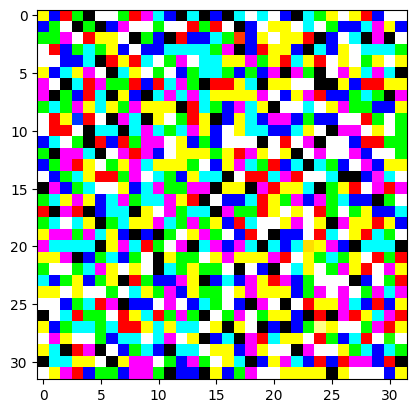

In [10]:
# test model denoising
out = model.sample(batch_size=1, input_channels=config["ddpm__input_image_channels"])
plt.imshow(to_pil(inv_t(out.cpu()[0])))

# Train

In [11]:
callbacks = [
    EarlyStopping(
        monitor="train_loss__step",
        min_delta=-float('inf'),       # always accept
        patience=5,
        verbose=False,
        check_finite=True,
        mode="min",
    ),
]
logger = None

validate_every_n_steps = (steps_per_epoch * config["num_epoch"]) // 100

if config["log_wandb"]:
    logger = WandbLogger(project=project_name, prefix="CIFAR")
    
    try:
        logger.watch(model)
    except ValueError as e:
        if "You can only call `wandb.watch` once per model." not in str(e):
            raise e
            
    callbacks.append(
        SampleCallback(
            logger=logger, 
            inv_normaliser=make_inv_normaliser(), 
            every_n_steps=validate_every_n_steps, 
            batch_size=4,
            input_channels=config["ddpm__input_image_channels"],
        )
    )
    callbacks.append(
        DenoiseMidwaySampleCallback(
            logger=logger, 
            seed_img_transformed=test_dataset[12][0],
            noise_at_ts=[100, 50, 10],
            every_n_steps=validate_every_n_steps,
            inv_normaliser=make_inv_normaliser()
        )
    )

    callbacks.append(
        ModelCheckpoint(
            dirpath=f"s3://deep-learning-personal-projects/{project_name}/{run.id}/",
            filename="{epoch}-{step}--valid_loss={valid_loss__epoch:.3f}",
            monitor="valid_loss__epoch",
            save_last=True,
            train_time_interval=datetime.timedelta(minutes=45),
            save_top_k=1,
            mode="min",
            enable_version_counter=False,
        )
    )

    callbacks.append(LearningRateMonitor(logging_interval='step'))

trainer = Trainer(
    accelerator="gpu" if device == "cuda" else "cpu", 
    devices=1, 
    max_epochs=config["num_epoch"],
    log_every_n_steps=config["accumulate_grad_batches"], # if accumulate, reduce logging frequency since we only do one optimisation step after X batches
    precision=32,
    logger=logger,
    callbacks=callbacks,
    accumulate_grad_batches=config["accumulate_grad_batches"],
    overfit_batches=config["overfit_batch"],
    max_time=config["max_trainer_time_limit"],
    check_val_every_n_epoch=None,
    val_check_interval=validate_every_n_steps * config["accumulate_grad_batches"],
)

trainer.fit(
    model, 
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,   
    ckpt_path=(
        f"s3://deep-learning-personal-projects/{project_name}/{config['use_existing_run']}/last.ckpt" 
        if config["use_existing_run"]
        else None
    )
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory s3://deep-learning-personal-projects/test-ddpm-lightning/setviymk/ exists and is not empty.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/training_epoch_loop.py:221: You're resuming from a checkpoint that ended before the epoch ended and your dataloader is not resumable. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint or make your dataloader resumable by implementing the `state_dict` / `load_state_dict` interface.
/usr/local/lib/python3.10/dist-packages/wandb/wandb_torch.py:193: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  check = torch.cuda.FloatTensor(1).fill_(0)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='valid_loss__epoch')` could not find the monitored key in the returned metrics: ['train_loss__step', 'lr-Adam', 'epoch', 'ste

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

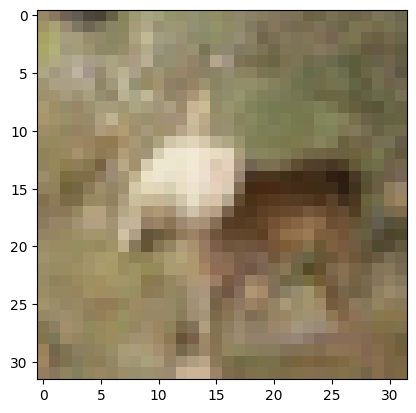

In [12]:
# test model denoising after training
out = model.sample(batch_size=1, input_channels=config["ddpm__input_image_channels"])
plt.imshow(to_pil(inv_t(out.cpu()[0])))

In [13]:
if log_wandb:
    wandb.finish()

CIFAR-epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
CIFAR-lr-Adam,████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
CIFAR-train_loss__step,▂▂▆▁▄▇▃▆▄█▆▃▃▃▄▃▄▅▅▂▃▅▂▄▃▄▂▃▂▃▄▄▂▆▃▇▅▂▅▆
CIFAR-valid_loss__epoch,▂▁█▆
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
CIFAR-epoch,150
CIFAR-lr-Adam,9e-05
CIFAR-train_loss__step,0.01937
CIFAR-valid_loss__epoch,0.01721
trainer/global_step,58722
